In [168]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
import IPython.display

In [169]:
pd.set_option("display.max_row", 200)

In [170]:
df = pd.read_csv("data/all_data_aggr_nonan.csv", index_col=0)

In [171]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
              'activity', 'screen', 'call', 'sms', 'appCat.builtin',
              'appCat.communication', 'appCat.entertainment', 'appCat.finance',
              'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
              'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days'  # always correct
IN_STEPS = 20  # use 7 days
OUT_STEPS = 1  # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

In [172]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

test_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)

test_window.update_datasets(train_series, val_series, test_series, norm=True)

In [204]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='relu')
])

MAX_EPOCHS = 20

In [205]:
def compile_and_fit(model, window, patience=2, loss=tf.keras.losses.MeanSquaredError()):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [206]:
history = compile_and_fit(lstm_model, test_window)
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(test_window.val)
performance['LSTM'] = lstm_model.evaluate(test_window.test, verbose=0)
mse_model = lstm_model

Epoch 1/20
61/61 [==============================] - 10s 70ms/step - loss: 0.0936 - mean_absolute_error: 0.2542 - mean_squared_error: 0.0936 - val_loss: 0.0931 - val_mean_absolute_error: 0.2605 - val_mean_squared_error: 0.0931
Epoch 2/20
61/61 [==============================] - 3s 40ms/step - loss: 0.0676 - mean_absolute_error: 0.2130 - mean_squared_error: 0.0676 - val_loss: 0.0501 - val_mean_absolute_error: 0.1687 - val_mean_squared_error: 0.0501
Epoch 3/20
61/61 [==============================] - 3s 36ms/step - loss: 0.0616 - mean_absolute_error: 0.1971 - mean_squared_error: 0.0616 - val_loss: 0.0542 - val_mean_absolute_error: 0.1593 - val_mean_squared_error: 0.0542
Epoch 4/20
27/27 [==============================] - 2s 8ms/step - loss: 0.0581 - mean_absolute_error: 0.1461 - mean_squared_error: 0.0581


In [178]:
history = compile_and_fit(lstm_model, test_window, loss=tf.keras.losses.MeanAbsoluteError())
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(test_window.val)
performance['LSTM'] = lstm_model.evaluate(test_window.test, verbose=0)
mae_model = lstm_model

Epoch 1/20
61/61 [==============================] - 8s 68ms/step - loss: 0.1573 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0502 - val_loss: 0.1287 - val_mean_absolute_error: 0.1287 - val_mean_squared_error: 0.0458
Epoch 2/20
61/61 [==============================] - 3s 37ms/step - loss: 0.1524 - mean_absolute_error: 0.1524 - mean_squared_error: 0.0472 - val_loss: 0.1045 - val_mean_absolute_error: 0.1045 - val_mean_squared_error: 0.0369
Epoch 3/20
61/61 [==============================] - 3s 36ms/step - loss: 0.1467 - mean_absolute_error: 0.1467 - mean_squared_error: 0.0472 - val_loss: 0.1070 - val_mean_absolute_error: 0.1070 - val_mean_squared_error: 0.0392
Epoch 4/20
27/27 [==============================] - 1s 6ms/step - loss: 0.1132 - mean_absolute_error: 0.1132 - mean_squared_error: 0.0419


In [293]:
def plot_error(self, mse_model, mae_model, plot_col=None, max_subplots=1, single=True):
    """Compare error between two models on the test set."""
    def test_data(self):
        result = getattr(self, '_test_data', None)
        if result is None:
            result = []
            for batch in self.test:
                result.append(batch)
            self._test_data = result
        return result
    label_col_index = self.label_columns_indices.get(plot_col, None)
    plt.figure(figsize=(12,8))
    data = test_data(test_window)
    errors1 = list()
    errors2 = list()
    for i,_ in enumerate(data):
        inputs, labels = data[i]
        predictions1 = mse_model(inputs)[:, label_col_index]
        predictions2 = mae_model(inputs)[:, label_col_index]
        expected = labels[:, label_col_index]
        errors1.append(np.array(predictions1[:,0,0]-expected[:,0,0,0]))
        errors2.append(np.array(predictions2[:,0,0]-expected[:,0,0,0]))

    errors = np.stack([np.concatenate(errors1, axis=0), np.concatenate(errors2, axis=0)], axis=0)
    sns.set(style="darkgrid")
    plt.figure(figsize=(8,3))
    sns.kdeplot(errors[0,:], fill=True, color="r", label="MSE model")
    sns.kdeplot(errors[1,:], fill=True, color="b", label="MAE model")
    plt.xlabel("Error on the test set.")
    plt.legend(facecolor='white', framealpha=1, edgecolor='black')

    plt.savefig("5_error_testset.png",bbox_inches="tight", dpi=300)

<Figure size 1200x800 with 0 Axes>

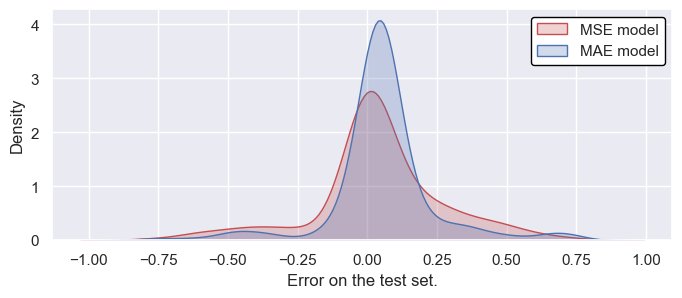

In [294]:
plot_error(test_window,mse_model, mae_model)

In [295]:
print("Loss, MAE, MSE")
print(mse_model.evaluate(test_window.test, verbose=0))
print(mae_model.evaluate(test_window.test, verbose=0))

Loss, MAE, MSE
[0.05740198493003845, 0.15231212973594666, 0.05740198493003845]
[0.11827214807271957, 0.11827214807271957, 0.03940853849053383]


In [296]:
np.arange(-2,2+1)

array([-2, -1,  0,  1,  2])

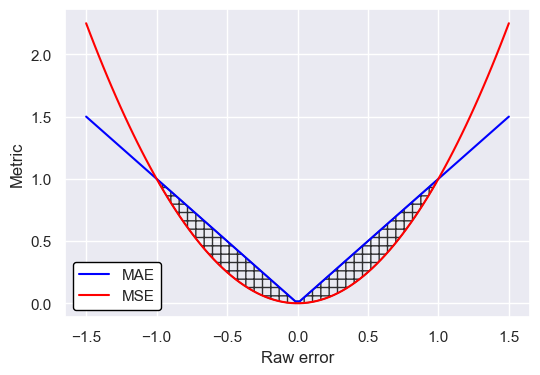

In [307]:
endpoint = 1.5
num = 100
x_coords =np.linspace(-endpoint,endpoint,num)
abs_line = np.abs(np.linspace(-endpoint,endpoint,num))
sqr_line = np.linspace(-endpoint,endpoint,num)**2
plt.figure(figsize=(12/2,8/2))
plt.plot(x_coords,abs_line,color="blue",label="MAE")
plt.plot(x_coords,sqr_line, color="red", label="MSE")
plt.fill_between(x_coords, abs_line, sqr_line, color="none", edgecolor="black",
                 alpha=0.8, hatch="++", where=((x_coords>=-1) & (x_coords<=1)))
plt.legend(facecolor='white', framealpha=1, edgecolor='black')
plt.ylabel("Metric")
plt.xlabel("Raw error")

plt.savefig("5_mse_mae_curves.png", bbox_inches="tight", dpi=300)